In [132]:
%matplotlib inline
import numpy as np
import pandas as pd
import theano.tensor as tt
import pymc3 as pm

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from IPython.core.pylabtools import figsize

sns.set_context('notebook')
plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.4.1


Leer los datos:
1. Dormir +/-1 hora
2. Dormir +/-2 hora
3. Despertar +/-1 hora
4. Despertar +/-2 hora


In [4]:
sleep1 = pd.read_csv("sleep1_data.csv")
sleep2 = pd.read_csv("sleep2_data.csv")
wake1 = pd.read_csv("wake1_data.csv")
wake2 = pd.read_csv("wake2_data.csv")

In [7]:
N_SAMPLES = 5000

sleep1_obs = sleep1['Sleep'].values
sleep1_time = sleep1['Offset'].values

sleep2_obs = sleep2['Sleep'].values
sleep2_time = sleep2['Offset'].values

wake1_obs = wake1['Sleep'].values
wake1_time = wake1['Offset'].values

wake2_obs = wake2['Sleep'].values
wake2_time = wake2['Offset'].values

### Estimador Maximum A Posterior (MAP)

In [46]:
def MAP(obs, time):#, method = 'BFGS'):
    with pm.Model() as model:
        # Create the alpha and beta parameters
        beta0 = pm.Normal('beta0', mu=0.0, tau=0.01, testval=0.0)
        beta1 = pm.Normal('beta1', mu=0.0, tau=0.01, testval=0.0)

        # Create the probability from the logistic function
        p = pm.Deterministic('p',  1 / (1 + np.exp(-(beta0 + beta1*time)))) 

        # Create the bernoulli parameter which uses the observed dat
        observed = pm.Bernoulli('obs', p, observed=obs)

        # Starting values are found through Maximum A Posterior estimation
        map_estimation = pm.find_MAP()#method='powell')
    return map_estimation

In [47]:
sleep1_map = MAP(sleep1_obs, sleep1_time)
sleep2_map = MAP(sleep2_obs, sleep2_time)
wake1_map = MAP(wake1_obs, sleep1_time)
wake2_map = MAP(wake2_obs, sleep2_time)

logp = -5,246.6, ||grad|| = 86,838: 100%|██████████| 5/5 [00:00<00:00, 635.15it/s]
logp = -10,487, ||grad|| = 4.2456e+05: 100%|██████████| 5/5 [00:00<00:00, 355.44it/s]
logp = nan, ||grad|| = 0: 100%|██████████| 84/84 [00:00<00:00, 685.48it/s]  
logp = nan, ||grad|| = 0: 100%|██████████| 84/84 [00:00<00:00, 453.03it/s]     


In [48]:
print(sleep1_map['beta0'], sleep1_map['beta1'])
print(sleep2_map['beta0'], sleep2_map['beta1'])
print(wake1_map['beta0'], wake1_map['beta1'])
print(wake2_map['beta0'], wake2_map['beta1'])

-0.2212745533256365 20.998834195546443
-0.04699037120114722 20.99994742624406
0.00464805988112128 -0.9999891977113261
0.0019553340609352312 -0.9999980883325278


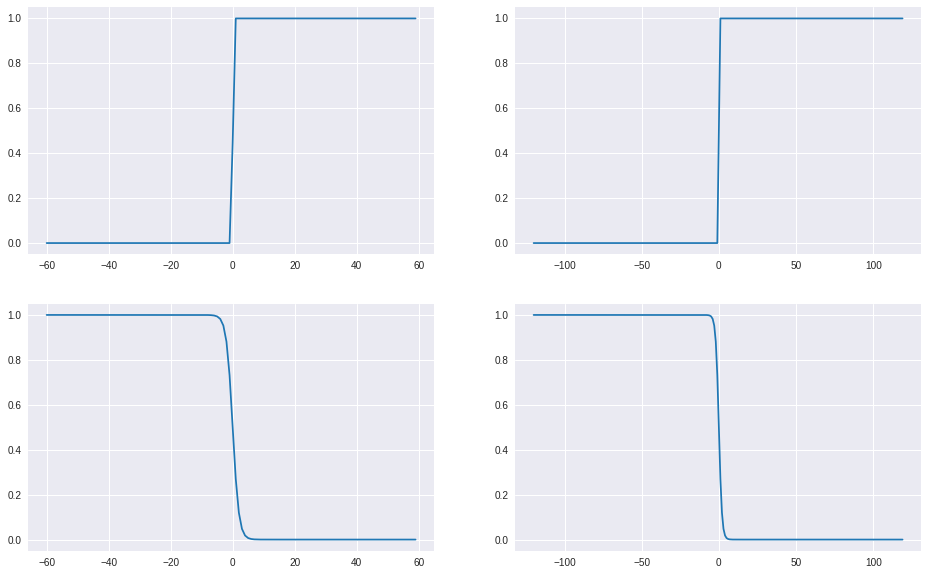

In [63]:
plt.figure(figsize=(16,10))

plt.subplot(221)
plt.plot(np.sort(sleep1_time), 1 / (1 + np.exp(-(sleep1_map['beta0'] + sleep1_map['beta1']*np.sort(sleep1_time)))))

plt.subplot(222)
plt.plot(np.sort(sleep2_time), 1 / (1 + np.exp(-(sleep2_map['beta0'] + sleep2_map['beta1']*np.sort(sleep2_time)))))

plt.subplot(223)
plt.plot(np.sort(wake1_time), 1 / (1 + np.exp(-(wake1_map['beta0'] + wake1_map['beta1']*np.sort(wake1_time)))))

plt.subplot(224)
plt.plot(np.sort(wake2_time), 1 / (1 + np.exp(-(wake2_map['beta0'] + wake2_map['beta1']*np.sort(wake2_time)))))

plt.show()

### Metropolis-Hasting con PyMC3

In [155]:
def metropolis_hasting(obs, time, samples, start=None):
    with pm.Model() as model:
        # Create the alpha and beta parameters
        beta0 = pm.Normal('beta0', mu=0.0, tau=0.01, testval=0.0)
        beta1 = pm.Normal('beta1', mu=0.0, tau=0.01, testval=0.0)

        # Create the probability from the logistic function
        p = pm.Deterministic('p',  1 / (1 + np.exp(-(beta0 + beta1*time)))) 

        # Create the bernoulli parameter which uses the observed dat
        observed = pm.Bernoulli('obs', p, observed=obs)

        # Using Metropolis Hastings Sampling
        step = pm.Metropolis()

        # Sample from the posterior using the sampling method
        trace = pm.sample(samples, step=step, njobs=1, start=start, chain=4);
        gelman = pm.gelman_rubin(trace)
    return model, trace

In [425]:
def gibbs(obs, time, samples, start=None):
    with pm.Model() as model:
        # Create the alpha and beta parameters
        beta0 = pm.Normal('beta0', mu=0.0, tau=0.01, testval=0.0)
        beta1 = pm.Normal('beta1', mu=0.0, tau=0.01, testval=0.0)

        # Create the probability from the logistic function
        p = pm.Deterministic('p',  1 / (1 + np.exp(-(beta0 + beta1*time)))) 

        # Create the bernoulli parameter which uses the observed dat
        observed = pm.Bernoulli('obs', p, observed=obs)

        # Using Metropolis Hastings Sampling
        #step = pm.BinaryGibbsMetropolis(['beta0', 'beta1'])
        step = pm.ElemwiseCategorical(['beta0'])
        # Sample from the posterior using the sampling method
        trace = pm.sample(samples, step=step, njobs=1, start=start, chain=4);
        gelman = pm.gelman_rubin(trace)
    return model, trace

In [426]:
sleep1_gibbs_model, sleep1_gibbs = gibbs(sleep1_obs, sleep1_time, N_SAMPLES)

AttributeError: 'str' object has no attribute 'owner'

### Plots

In [136]:
# Labels para plots
sleep_labels = ['8:00','8:30','9:00', '9:30', '10:00', '10:30', '11:00', '11:30', '12:00']
wake_labels = ['4:00','4:30','5:00', '5:30', '6:00', '6:30', '7:00', '7:30', '8:00']

In [118]:
def plot_hist(beta0, beta1, samples):
    figsize(16, 10)

    plt.subplot(211)
    plt.title(r"""Distribucion de $\beta_0$ con %d muestras""" % samples)
    plt.hist(beta0, histtype='stepfilled', color = 'darkred', bins=30, density=True);
    plt.ylabel('Densidad de probabilidad')
    
    plt.subplot(212)
    plt.title(r"""Distribucion de $\beta_1$ con %d muestras""" % samples)
    plt.hist(beta1, histtype='stepfilled', color = 'darkblue', bins=30, density=True)
    plt.ylabel('Densidad de probabilidad');

In [134]:
def plot_fit(time_est, sleep_est, time, obs, samples, title, m, labels):
    figsize(16, 6)
    
    plt.plot(time_est, sleep_est, color = 'navy', lw=3, label="Modelo logistico")
    plt.scatter(time, obs, edgecolor = 'slateblue', s=50, alpha=0.2, label='obs')
    plt.suptitle(title)
    plt.title('Distribución de probabilidad con %d muestras' % samples);
    plt.legend(prop={'size':18})
    plt.ylabel('Probabilidad')
    plt.xlabel('Hora ' + m);
    plt.xticks([-120,-90,-60, -30, 0, 30, 60, 90, 120], labels);

In [216]:
def plot_fit_colormap(trace, time, labels, m):
    colors  =  ["#348ABD" , "#A60628", "#7A68A6"]
    cmap = clr.LinearSegmentedColormap.from_list("BMH", colors)
    figsize(14, 7)
    probs = trace['p']
    plt.scatter(time, probs.mean(axis=0), cmap = cmap, c = probs.mean(axis=0), s = 50);
    plt.title('Probabilidad de dormir como función del tiempo')
    plt.ylabel('Probabilidad')
    plt.xlabel('Hora ' + m)
    plt.xticks([-120,-90,-60, -30, 0, 30, 60, 90, 120], labels);

### Métodos de convergencia

#### Métodos de convergencia gráficos

In [271]:
def graph_analysis(trace, title):
    pm.traceplot(trace, ['beta0', 'beta1'], figsize=(12,6));
    pm.autocorrplot(trace = trace, varnames = ['beta0', 'beta1'], figsize=(12,6)); #no se muestra, pero si se quieta no se ve el traceplot .-.
    pm.forestplot(trace, varnames=['beta0', 'beta1']);
    pm.autocorrplot(trace = trace, varnames = ['beta0', 'beta1'], figsize=(12,6));

#### Métodos de convergencia más "formales"

In [326]:
def geweke(trace, first = 0.1, last = 0.5):
    score=pm.geweke(trace, first=first, last=last)
    
    figsize(16, 8)
    plt.suptitle('Geweke Plot Comparando el primer 10% con el ultimo 50%  de la diferenrencia en cada cadena en Z score')
    
    plt.subplot(221)
    plt.scatter(score[[*score][0]]['beta0'][:,0],score[[*score][0]]['beta0'][:,1], marker = 'o', s=100)
    plt.axhline(-1.98, c='r')
    plt.axhline(1.98, c='r')
    plt.ylim(-2.5,2.5)
    plt.xlim(0-10,.5*trace['beta0'].shape[0]/2+10)
    plt.title(r"""Primera cadena $\beta_0$""")
        
    plt.subplot(222)
    plt.scatter(score[[*score][0]]['beta1'][:,0],score[[*score][0]]['beta1'][:,1], marker = 'o', s=100)
    plt.axhline(-1.98, c='r')
    plt.axhline(1.98, c='r')
    plt.ylim(-2.5,2.5)
    plt.xlim(0-10,.5*trace['beta1'].shape[0]/2+10)
    plt.title(r"""Primera cadena $\beta_1$""")
        
    plt.subplot(223)
    plt.scatter(score[[*score][-1]]['beta0'][:,0],score[[*score][-1]]['beta0'][:,1], marker = 'o', s=100)
    plt.axhline(-1.98, c='r')
    plt.axhline(1.98, c='r')
    plt.ylim(-2.5,2.5)
    plt.xlim(0-10,.5*trace['beta0'].shape[0]/2+10)
    plt.title(r"""Segunda cadena $\beta_0$""")
        
    plt.subplot(224)
    plt.scatter(score[[*score][-1]]['beta1'][:,0],score[[*score][-1]]['beta1'][:,1], marker = 'o', s=100)
    plt.axhline(-1.98, c='r')
    plt.axhline(1.98, c='r')
    plt.ylim(-2.5,2.5)
    plt.xlim(0-10,.5*trace['beta1'].shape[0]/2+10)
    plt.title(r"""Segunda cadena $\beta_1$""")
    plt.show()

In [345]:
def gelman_rubin(trace):
    conv = pm.gelman_rubin(trace, ['beta0', 'beta1'])
    print("Convergencia de Gelman-Rubin")
    if(conv['beta0'] > 1.0 and conv['beta0'] <1.1):
        print("\t El parámetro beta0 ha convergido")
    print("\t \t beta0: ", conv['beta0'])
    if(conv['beta1'] > 1.0 and conv['beta1'] <1.1):
        print("\t El parámetro beta1 ha convergido")
    print("\t \t beta1: ", conv['beta1'])

In [415]:
def running_means(trace):
    chains = []
    for i in trace.chains:
        beta0 = trace.get_values('beta0', chains=i)
        beta1 = trace.get_values('beta1', chains=i)
        means_beta0 = []
        means_beta1 = []
        for i in range(1,len(trace)):
            means_beta0 = np.append(means_beta0, sum(beta0[:i])/i)
            means_beta1 = np.append(means_beta1, sum(beta1[:i])/i)
        chains.append([means_beta0, means_beta1])
    
    i=0
    for chain in chains:
        i+=1
        x_axis = range(len(trace)-1)
        plt.figure(figsize=(15, 5))
        plt.suptitle("Running means para la cadena numero " + str(i))
        plt.subplot(121)
        plt.plot(x_axis, chain[0])
        plt.xlabel("Iteraciones")
        plt.ylabel("beta0")

        plt.subplot(122)
        plt.plot(x_axis, chain[1])
        plt.xlabel("Iteraciones")
        plt.ylabel("beta1")
        plt.show()

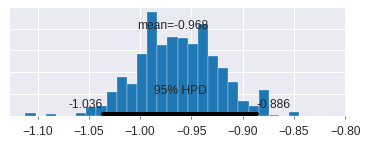

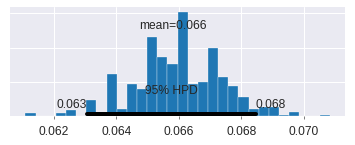

In [233]:
pm.plot_posterior(trace=sleep1_met['beta0']);
pm.plot_posterior(trace=sleep1_met['beta1']);

In [239]:
np.mean(sleep1_met.get_values('beta0'))
pm.summary(sleep1_met, ['beta0', 'beta1'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta0,-0.968011,0.039323,0.002375,-1.036360,-0.886097,156.115043,1.002713
beta1,0.065793,0.001382,0.000096,0.063071,0.068461,96.365806,1.008598


## Modelo Dormir +/-1 hora

In [156]:
sleep1_met_model, sleep1_met = metropolis_hasting(sleep1_obs, sleep1_time, N_SAMPLES)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [beta1]
>Metropolis: [beta0]
100%|██████████| 5500/5500 [00:22<00:00, 246.47it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


#### Histograma de los parámetros estimados $\beta_0$ y $\beta_1$

Distriución posterior de los parámetros $\beta_0$ y $\beta_1$

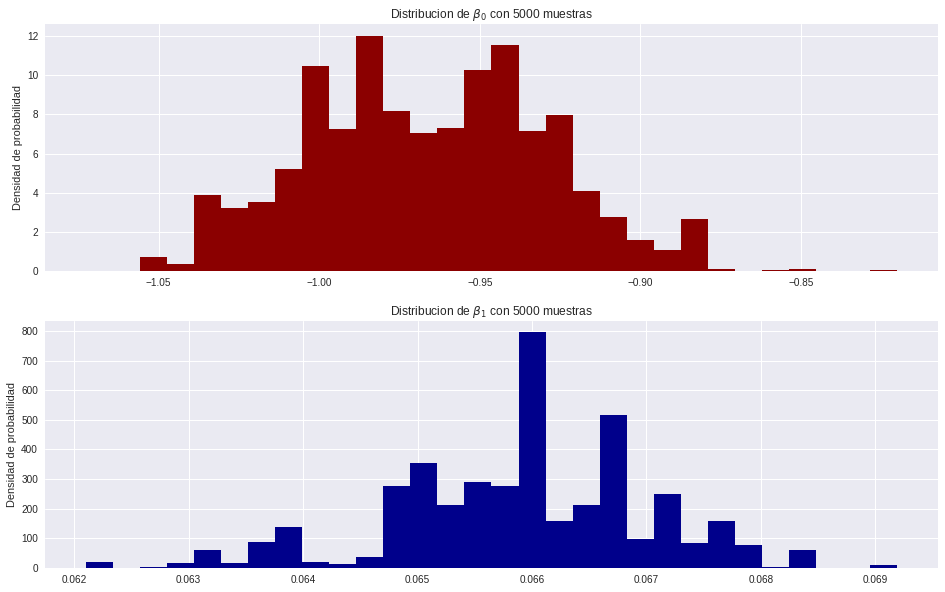

In [157]:
beta0_sleep1_met = sleep1_met["beta0"][5000:, None]
beta1_sleep1_met = sleep1_met["beta1"][5000:, None]
plot_hist(beta0_sleep1_met, beta1_sleep1_met, N_SAMPLES)

Todas las muestras de $\beta_0$ son menores que 0, lo que para este modelo implicaría que se duerme después de las 10:00 pm, pues si las muestras de $\beta_0$ estuviesen centrado en 0 querría decir que se duerme a las 10:00PM

Todas las muestras de $\beta_1$ son mayores a 0, lo que implicaría la dirección de la pendiente...

In [158]:
reg_logistic = lambda x, beta0, beta1 : 1 / (1 + np.exp(-(beta0 + beta1*x)))

# Time values for probability prediction
time_est = np.linspace(sleep1_time.min()- 15, sleep1_time.max() + 15)[:, None]

# Take most likely parameters to be mean values
beta0_sleep1_met_est = beta0_sleep1_met.mean()
beta1_sleep1_met_est = beta1_sleep1_met.mean()

# Probability at each time using mean values of alpha and beta
sleep_est = reg_logistic(time_est, beta0=beta0_sleep1_met_est, beta1=beta1_sleep1_met_est)

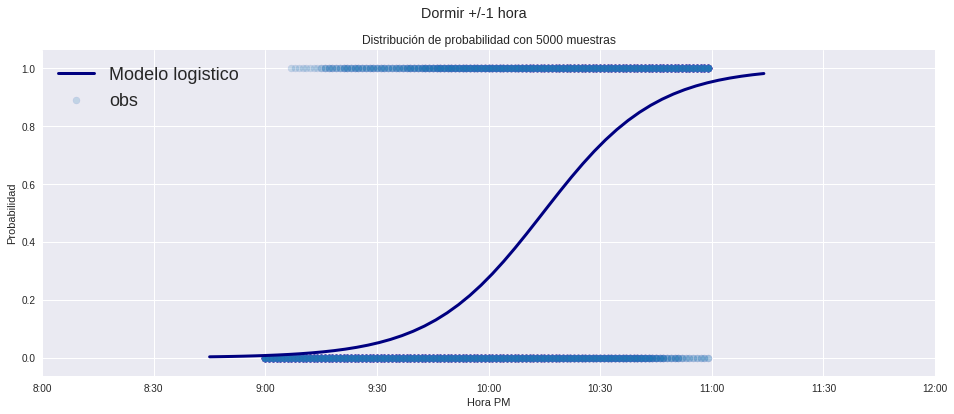

In [159]:
plot_fit(time_est, sleep_est, sleep1_time, sleep1_obs, N_SAMPLES, "Dormir +/-1 hora", "PM", sleep_labels)

In [160]:
print('The probability of sleep increases to above 50% at 10:{} PM.'.format(int(time_est[np.where(sleep_est > 0.5)[0][0]][0])))

The probability of sleep increases to above 50% at 10:16 PM.


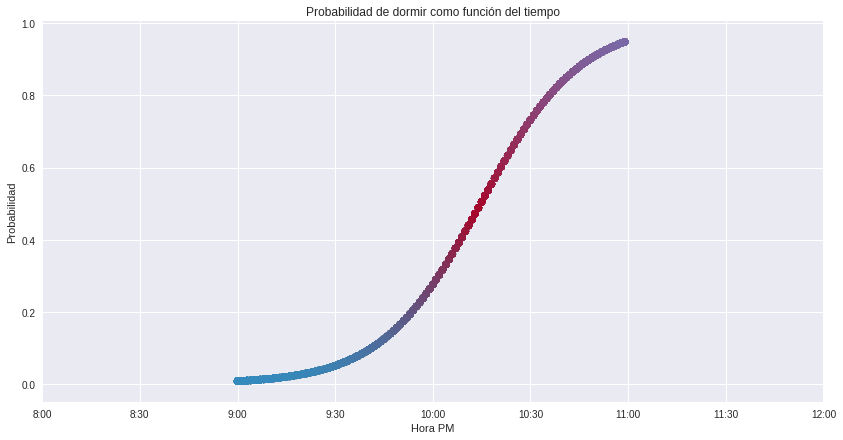

In [217]:
plot_fit_colormap(sleep1_met, sleep1_time, sleep_labels, "PM")

In [162]:
print('10:00 PM probability of being asleep: {:.2f}%.'.format(100 * reg_logistic(0, beta0_sleep1_met_est, beta1_sleep1_met_est)))
print('9:30  PM probability of being asleep: {:.2f}%.'.format(100 * reg_logistic(-30, beta0_sleep1_met_est, beta1_sleep1_met_est)))
print('10:30 PM probability of being asleep: {:.2f}%.'.format(100 * reg_logistic(30, beta0_sleep1_met_est, beta1_sleep1_met_est)))

10:00 PM probability of being asleep: 27.57%.
9:30  PM probability of being asleep: 5.00%.
10:30 PM probability of being asleep: 73.34%.


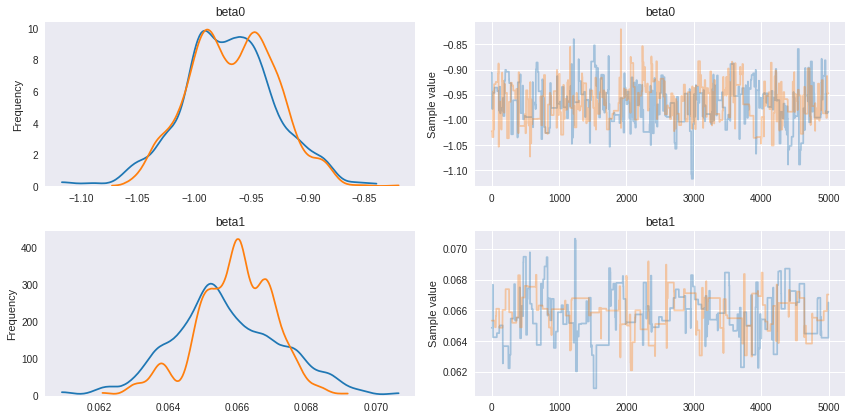

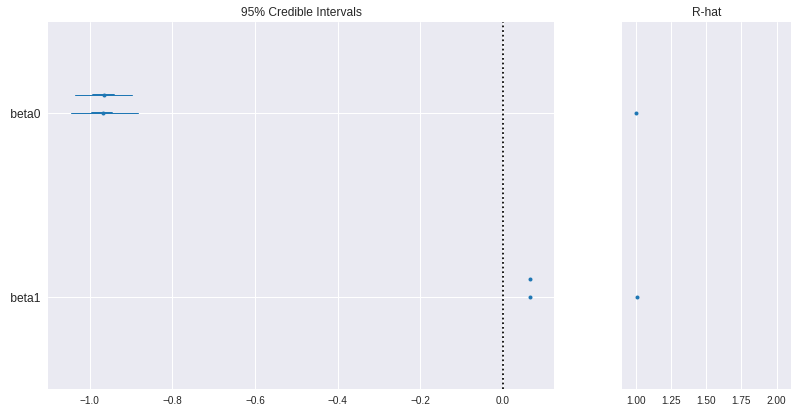

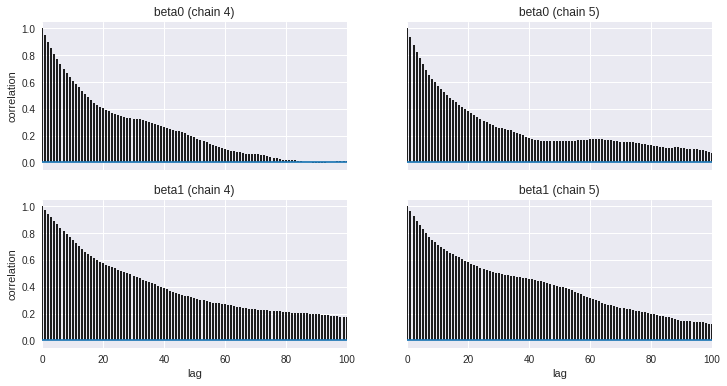

In [272]:
graph_analysis(sleep1_met, "Dormido +/-1 hora");

In [275]:
score=pm.geweke(sleep1_met, first=0.1, last=0.5, intervals=20)
score

{4: {'beta0': array([[ 0.00000000e+00,  3.40692168e-01],
         [ 1.31000000e+02,  1.38425019e-01],
         [ 2.62000000e+02,  1.48218133e-01],
         [ 3.93000000e+02, -1.93700374e-02],
         [ 5.24000000e+02, -7.28199412e-02],
         [ 6.55000000e+02,  3.19582548e-02],
         [ 7.86000000e+02, -1.47492900e-01],
         [ 9.17000000e+02,  1.09823453e-01],
         [ 1.04800000e+03,  1.39939064e-01],
         [ 1.17900000e+03,  4.01277453e-01],
         [ 1.31000000e+03,  5.95236412e-01],
         [ 1.44100000e+03,  4.11535323e-01],
         [ 1.57200000e+03, -5.78881442e-02],
         [ 1.70300000e+03, -1.77205385e-01],
         [ 1.83400000e+03, -1.10003709e-01],
         [ 1.96500000e+03, -7.72308470e-03],
         [ 2.09600000e+03, -4.15944731e-01],
         [ 2.22700000e+03, -5.17006305e-01],
         [ 2.35800000e+03, -1.97718338e-02],
         [ 2.48900000e+03, -2.26932789e-02]]),
  'beta1': array([[ 0.00000000e+00, -3.76790095e-01],
         [ 1.31000000e+02, -1.32

In [306]:
print(score.keys())
[*score][-1]

dict_keys([4, 5])


5

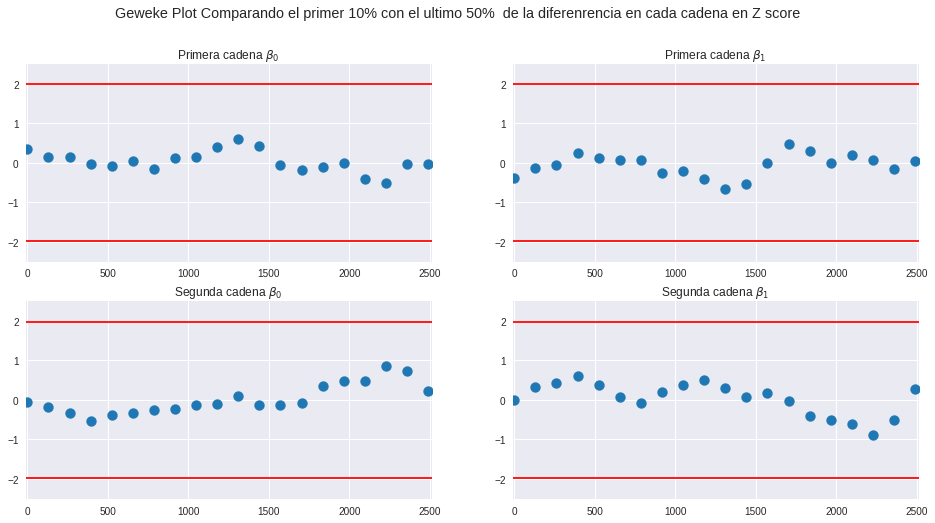

In [327]:
geweke(sleep1_met)

In [346]:
gelman_rubin(sleep1_met)

Convergencia de Gelman-Rubin
	 El parámetro beta0 ha convergido
	 	 beta0:  1.0027133302923512
	 El parámetro beta1 ha convergido
	 	 beta1:  1.008598462825289


In [383]:
print(len(sleep1_met.get_values('beta0', burn=1000,  chains=sleep1_met.chains[0])))
print(sleep1_met.get_values('beta0', burn=1000, chains=sleep1_met.chains[-1]))
len(sleep1_met)

4000
[-0.90847962 -0.90847962 -0.90847962 ... -0.94720739 -0.94720739
 -0.94720739]


5000

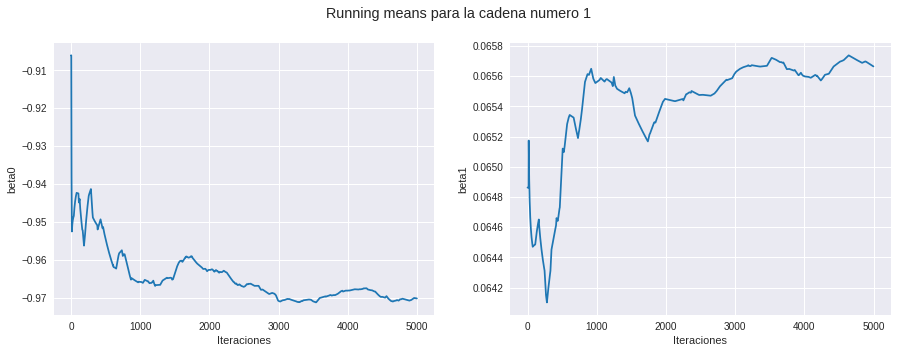

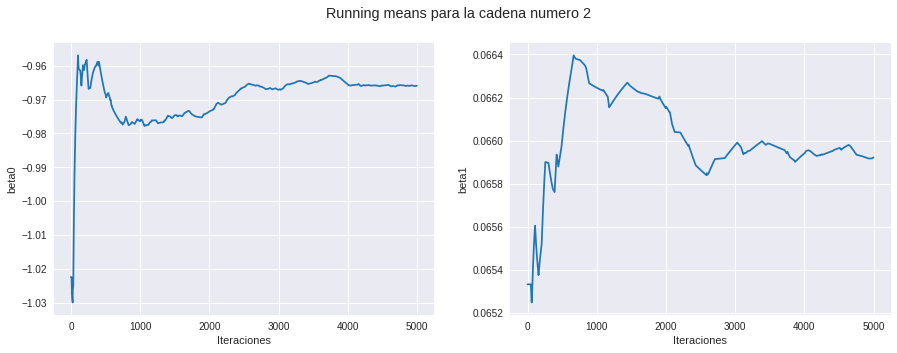

In [416]:
running_means(sleep1_met)

### OTROS~~

In [283]:
pm.effective_n(sleep1_met)

{'beta0': 156.1150427338717,
 'beta1': 96.36580588923081,
 'p': array([ 89.52395334,  89.61398274,  89.70785895, ..., 136.03530203,
        134.58471801, 133.21239375])}

In [164]:
t = time_est
p_t = reg_logistic(t.T, beta0_sleep1_met, beta1_sleep1_met)

mean_prob_t = p_t.mean(axis=0)

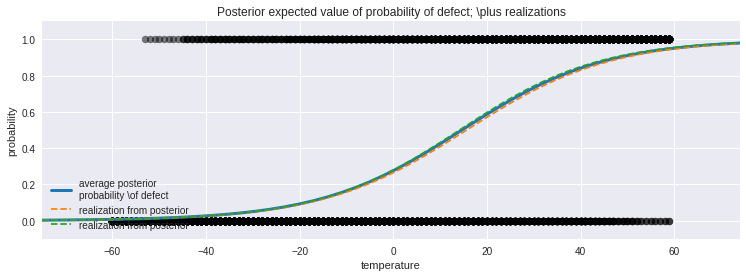

In [165]:
figsize(12.5, 4)

plt.plot(t, mean_prob_t, lw=3, label="average posterior \nprobability \of defect")
plt.plot(t, p_t[0, :], ls="--", label="realization from posterior")
plt.plot(t, p_t[-2, :], ls="--", label="realization from posterior")
plt.scatter(sleep1_time, sleep1_obs, color="k", s=50, alpha=0.5)
plt.title("Posterior expected value of probability of defect; \plus realizations")
plt.legend(loc="lower left")
plt.ylim(-0.1, 1.1)
plt.xlim(t.min(), t.max())
plt.ylabel("probability")
plt.xlabel("temperature");

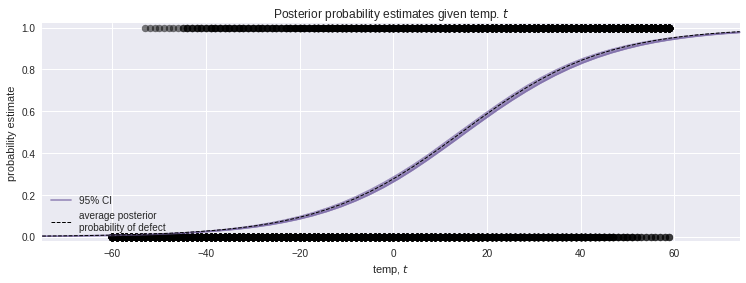

In [166]:
from scipy.stats.mstats import mquantiles

# vectorized bottom and top 2.5% quantiles for "confidence interval"
qs = mquantiles(p_t, [0.025, 0.975], axis=0)
plt.fill_between(t[:, 0], *qs, alpha=0.7,
                 color="#7A68A6")

plt.plot(t[:, 0], qs[0], label="95% CI", color="#7A68A6", alpha=0.7)

plt.plot(t, mean_prob_t, lw=1, ls="--", color="k",
         label="average posterior \nprobability of defect")

plt.xlim(t.min(), t.max())
plt.ylim(-0.02, 1.02)
plt.legend(loc="lower left")
plt.scatter(sleep1_time, sleep1_obs, color="k", s=50, alpha=0.5)
plt.xlabel("temp, $t$")

plt.ylabel("probability estimate")
plt.title("Posterior probability estimates given temp. $t$");

In [418]:
from theano.printing import pydotprint

pydotprint(sleep1_met)

AssertionError: 

In [202]:
#>:c ñaaa
tr1 = sleep1_met[500::5]
print(tr1)
postpred = pm.sample_ppc(sleep1_met, samples=1000, model=sleep1_met_model)

  0%|          | 0/1000 [00:00<?, ?it/s]

<MultiTrace: 2 chains, 900 iterations, 3 variables>


KeyError: 1

## Modelo Dormir +/-2 hora